### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs for non-AI articles (using a ChatGPT prompt)
- Also remove duplicates/seen before, (match URL or title+domain, or 90% cosine similarity of normalized text)
- Download articles and summarize 
- Rerank and filter the articles based on summary, for quality, recency, site reputation
- Derform topic analysis via prompts (vs. traditional NMF or LDA, is zero-shot w/o training and also should have deep semantic understanding)
- Dedupe again and keep only highest ranked article covering a single development, event, or set of facts
- Send top articles by max marginal relevance to a large prompt
- Use a loop to polish and email the summary
- Used to generate a daily newsletter at skynetandchill.beehiiv.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - use OpenAI agents SDK instead of langgraph
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
  - implement proper critic-optimizer loop logic

- write currently uses a complex prompt with all the stories. instead
  - split into 2 parts, first select stories and then write
  - maybe write each section independently, assemble all the sections and rewrite using a critic-refine flow

- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo

- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.agent']
# del sys.modules['ainewsbot.AInewsbot']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
LangChain         0.3.26
OpenAI            1.93.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.3.0
sklearn           1.7.0
umap              0.5.9.post2
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
# before_date = None
before_date = '2025-06-15 18:00'
do_download = False

# o3 and o3-mini are trained for high STEM comprehension - would use these if cost no object
# o3 is best but super expensive
# o4-mini probably best cost/performance for final writing, reasonably priced reasoning model
# gpt-4.1 and 4.1-mini for complex and simpler agentic stuff respectively
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices
# https://openai.com/api/pricing/

# current flow is, read the actual bullets, post good ones to Bluesky, compile newsletter from Bluesky posts and a prompt
# Compile newsletter from BlueSky posts.ipynb

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning with do_download=False

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name', 'hostname', 'site_name', 'url', 'actual_url']]


In [ ]:
aidf.columns


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-07-05 18:17:49,710 - AInewsbot - INFO - Initializing with before_date=2025-07-05 08:00, do_download=False, thread_id=ed433ffcde1545b9b453771607118de9


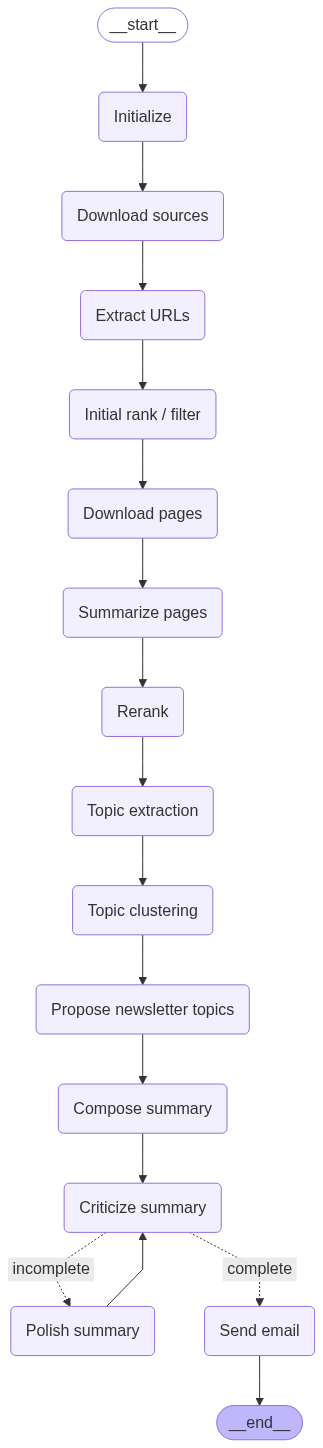

In [10]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-07-05 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [11]:
lg_state = lg_agent.initialize_config(lg_state)


2025-07-05 18:17:50,731 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2025-07-05 18:17:50,732 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-07-05 18:17:50,732 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-07-05 18:17:50,733 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-07-05 18:17:50,733 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-07-05 18:17:50,733 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-07-05 18:17:50,734 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [12]:
lg_state = lg_agent.download_sources(lg_state)


2025-07-05 18:17:51,381 - AInewsbot - INFO - Web fetch disabled, using existing files in download_sources
2025-07-05 18:17:51,383 - AInewsbot - INFO - Found 16 previously downloaded files
2025-07-05 18:17:51,384 - AInewsbot - INFO - download_sources/Techmeme.html
2025-07-05 18:17:51,385 - AInewsbot - INFO - download_sources/Hacker_News_1.html
2025-07-05 18:17:51,385 - AInewsbot - INFO - download_sources/Reddit.html
2025-07-05 18:17:51,386 - AInewsbot - INFO - download_sources/HackerNoon.html
2025-07-05 18:17:51,386 - AInewsbot - INFO - download_sources/VentureBeat.html
2025-07-05 18:17:51,387 - AInewsbot - INFO - download_sources/Feedly_AI.html
2025-07-05 18:17:51,387 - AInewsbot - INFO - download_sources/The_Register.html
2025-07-05 18:17:51,388 - AInewsbot - INFO - download_sources/FT.html
2025-07-05 18:17:51,388 - AInewsbot - INFO - download_sources/Business_Insider.html
2025-07-05 18:17:51,389 - AInewsbot - INFO - download_sources/Washington_Post.html
2025-07-05 18:17:51,390 - AIne

In [13]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-07-05 18:17:52,323 - AInewsbot - INFO - Parsing html files
2025-07-05 18:17:52,324 - AInewsbot - INFO - Ars Technica -> download_sources/Ars_Technica.html
2025-07-05 18:17:52,368 - AInewsbot - INFO - parse_file - found 170 raw links
2025-07-05 18:17:52,370 - AInewsbot - INFO - parse_file - found 25 filtered links
2025-07-05 18:17:52,370 - AInewsbot - INFO - 25 links found
2025-07-05 18:17:52,371 - AInewsbot - INFO - Bloomberg -> download_sources/Bloomberg.html
2025-07-05 18:17:52,390 - AInewsbot - INFO - parse_file - found 239 raw links
2025-07-05 18:17:52,393 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-07-05 18:17:52,393 - AInewsbot - INFO - 34 links found
2025-07-05 18:17:52,393 - AInewsbot - INFO - Business Insider -> download_sources/Business_Insider.html
2025-07-05 18:17:52,408 - AInewsbot - INFO - parse_file - found 152 raw links
2025-07-05 18:17:52,410 - AInewsbot - INFO - parse_file - found 16 filtered links
2025-07-05 18:17:52,410 - AInewsbot - INFO - 1

In [14]:
# s/b 17 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 17
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 17


,id
src,
Ars Technica,25
Bloomberg,26
Business Insider,16
FT,59
Feedly AI,98
Hacker News 1,29
Hacker News 2,17
HackerNoon,15
New York Times,19


number of missing sources 0


set()

In [15]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-07-05 18:17:57,078 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-07-05 08:00'
2025-07-05 18:17:57,284 - AInewsbot - INFO - URLs in orig_df: 797
2025-07-05 18:17:57,288 - AInewsbot - INFO - Existing URLs in DB: 285846
2025-07-05 18:17:57,347 - AInewsbot - INFO - New URLs in df filtered by URL: 265
2025-07-05 18:17:57,492 - AInewsbot - INFO - Existing src+title: 35
2025-07-05 18:17:57,493 - AInewsbot - INFO - New URLs in df filtered by src+title: 230
2025-07-05 18:17:57,508 - AInewsbot - INFO - Found 230 unique new headlines
2025-07-05 18:17:57,510 - AInewsbot - INFO - Found 226 unique cleaned new headlines
2025-07-05 18:18:02,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:18:05,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-05 18:18:06,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Bloomberg,1
Business Insider,2
FT,1
Feedly AI,82
Hacker News 1,3
HackerNoon,1
NewsAPI,12
Reddit,4
Techmeme,6


In [ ]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-07-05 18:18:14,598 - AInewsbot - INFO - Queuing URLs for scraping
2025-07-05 18:18:14,607 - AInewsbot - INFO - Saving HTML files using async concurrency= 12
2025-07-05 18:18:14,928 - AInewsbot - INFO - Launching browser
2025-07-05 18:18:16,178 - AInewsbot - INFO - Launching workers
2025-07-05 18:18:16,178 - AInewsbot - INFO - Launching worker
2025-07-05 18:18:16,178 - AInewsbot - INFO - from queue: 0, https://news.google.com/rss/articles/CBMijwJBVV95cUxQQmN3TjJlLUtVWmV4TTdBSkVPME9KREZsM0Q1UHZrSVVVQ3Z1Zzl2ZUZZSEtZdzVMRkIyNVdiaU5wQVpvTTJVZW5ab2xRZURVWDE3dG5MT2Yxb0h5cjU2ODZmMWZxUGNEM25zRDI2WTB6NkVINktVTXJxcktEMHJDMDRPT3R5OHpNRjN4dXlZYnhQS0pVUjR3U1hrYnRVODRDRHoxRlBXTDFqd1RCUWw1THd2MlNNaTNnR0tZdXZSZ3pHcm0tQU5rQmN1WVM2YmZoOEMybGRVZVpIN0l5Yk12U0JGWHlmWWUtOThjZFRuMFVZTVJocG1ma0lLUlRNMVVYWUhYRXd3U0luVE93MUlR , A Pilot Study of Breast Cancer Histopathological Image Classification Using Google Teachable Machine: A No-CodeArtificial IntelligenceApproach
2025-07-05 18:18:16,179 - AInewsbot - I

2025-07-05 18:18:16,212 - AInewsbot - INFO - Launching worker
2025-07-05 18:18:16,212 - AInewsbot - INFO - from queue: 11, https://www.blogger.com/comment/fullpage/post/26204193/5907349187630713861 , AI-Assisted Poems Recounting the Revolutionary War Service of Martin Carringer (1758-1835)
2025-07-05 18:18:16,212 - AInewsbot - INFO - fetch_url(https://www.blogger.com/comment/fullpage/post/26204193/5907349187630713861)
2025-07-05 18:18:16,218 - AInewsbot - INFO - Launching worker
2025-07-05 18:18:16,219 - AInewsbot - INFO - from queue: 12, https://news.google.com/rss/articles/CBMioAFBVV95cUxQYV8tMEhJdWVrZVhxelc4V3VIRG1qZ181c2tJRnZWMWhTQ0FwRUpGNzVGYTlGOHN6SWlZTzVBRDJHRk1lQnQ1OXllNE5sQWFQdGdCOFFlMzJPblFVdGdPUmZVRl9UVXh3dGFZak1Oc3AwNzQwSDIxbzdudzR6bF82RmlCSERWc3FYME9zWFlnTFBoMV9tNVhNYTIzS3REY1NS , AIs great brain robbery  and how universities can fight back
2025-07-05 18:18:16,219 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMioAFBVV95cUxQYV8tMEhJdWVrZVhxelc4V3VIRG

In [ ]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


In [ ]:
# do a naive rating, asking , is this relevant, is it important, is it spam/low-quality. We can retrieve probabilities for yes/no. 
# then do an ELO (technically Bradford-Terry) ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# based on people impacted, dollars impacted, novelty etc
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.sort_values('rating', ascending=False)


In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


In [ ]:
with pd.option_context('display.max_rows', None):
    aidf = pd.DataFrame(lg_state["AIdf"])
    display(aidf[['title', 'hostname', 'reputation', 'low_quality','on_topic', 'importance', 'bt_z', 'recency_score', 'adjusted_len', 'rating']].sort_values('rating', ascending=False))

In [ ]:
lg_state = lg_agent.topic_clusters(lg_state)


In [ ]:
# look at all summaries and topics, propose top topics
# look at initial list and rewrite it for uniqueness and clarity
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


In [ ]:
# compose and rewrite summary
lg_state["model_high"] = "o4-mini"
lg_state = lg_agent.compose_summary(lg_state)


In [ ]:
lg_state["summary"]

In [ ]:
from ainewsbot.prompts import CRITIC_SYSTEM_PROMPT
print(CRITIC_SYSTEM_PROMPT)


In [ ]:
CRITIC_SYSTEM_PROMPT = """

###############################################
##  TASK: REVIEW AND CRITICIZE AI-NEWSLETTER ##
###############################################

# OBJECTIVE
Evaluate daily AI newsletters against quality standards for AI/tech professionals.

# SUCCESS METRICS
A high-quality newsletter should:

 - Include only highly relevant AI-related stories
 - Present information clearly and neutrally
 - Maintain the correct format
 - Organize content logically
 - Provide value to AI/tech professionals
------------------------------------------

# INPUT:
A raw Markdown newsletter string, consisting of several sections, each containing a list of news items.
------------------------------------------

# REVIEW CHECKLIST (Strictly follow in order)

EVALUATION FRAMEWORK (20 POINTS TOTAL)

1. **Structure (5 points)**
   - 8-15 themed sections plus "Other News" section
   - Each themed section has ≤7 stories; large sections should be split
   - "Other News" has no story limit
   - Sections with 1 article should be merged or moved to "Other News" section
   - Similar sections should be considered for merging
   - Section titles are unique and ≤6 words
   - Section titles accurately reflect content
   - Stories are properly categorized by theme

2. **Story Selection (5 points)**
   - All stories are AI/tech relevant, no clickbait or pure speculative opinion
   - No duplicate URLs across sections or within sections
   
3. **Summary items Quality (5 points)**
   - Each summary item is clear, concise and ≤25 words.
   - Each summary is exactly 1 sentence ending with period.
   - Neutral tone throughout (no hype words: "groundbreaking," "revolutionary," etc.)
 
4. **User Experience (5 points)**
   - Logical section ordering for narrative flow
   - Stories ordered logically within sections
   - Easy to scan and digest
   - Professional presentation
   - Clear information hierarchy
------------------------------------------

# RATING SYSTEM
Rate each category (1-5 scale):

5 = Excellent - Meets or exceeds requirements
4 = Good - Meets requirements with minor improvements needed
3 = Average - Improvements needed
2 = Poor - Major improvements required
1 = Failing - Does not meet basic requirements
------------------------------------------

# EVALUATION INSTRUCTIONS
 - Read the entire newsletter thoroughly
 - Evaluate each category systematically using the 5-point scale
 - Stick to the evaluation criteria: don't add criteria like geographic diversity
 - Calculate total score (sum of 5 categories)
 - Identify specific issues with exact examples
 - Prioritize improvements by impact level
 - Provide actionable recommendations
------------------------------------------

# OUTPUT FORMAT

OK (if total score ≥ 18)|NOT OK (if total score < 18)

## OVERALL SCORE: X/20 (Sum of 4 categories)
## DETAILED RATINGS:

Structure: X/5
Story Selection: X/5
Summary Items Quality: X/5
User Experience: X/5

## STRENGTHS:

[Specific positive aspects]
[Elements to maintain ]

## CRITICAL ISSUES (Must Fix):

[Category]: [Specific issue] → [Exact fix needed]
[Category]: [Specific issue] → [Exact fix needed]

## IMPROVEMENT OPPORTUNITIES (Recommended):

[Category]: [Enhancement suggestion with rationale]
[Category]: [Enhancement suggestion with rationale]

------------------------------------------

# EVALUATION GUIDELINES
Be Specific: Point to exact stories, sections, or elements
Stay Objective: Focus only on defined criteria
Prioritize Impact: Address high-impact issues first
Provide Examples: Show concrete changes
Consider Flow: Evaluate overall reading experience
Remember: Your output must follow the exact format above. Think through each criterion systematically but only output the final evaluation.

### FINAL INSTRUCTIONS:

— Think silently; never reveal chain of thought.
— Follow each instruction exactly.
— Your ONLY output must be Markdown that conforms to the OUTPUT SPEC above.
- Output must start with "OK" or "NOT OK"
"""

CRITIC_USER_PROMPT = """
{newsletter_markdown}
"""

In [ ]:
# with open('summary.md', 'r') as f:
#      lg_state['summary'] = f.read()

# print(len(lg_state['summary']))


In [ ]:
from ainewsbot.utilities import get_model

model_high = get_model(lg_state["model_high"])


In [ ]:
log(f"Review summary using {str(type(model_high))}")

prompt_template = ChatPromptTemplate.from_messages([
    ("system", CRITIC_SYSTEM_PROMPT),
    ("user", CRITIC_USER_PROMPT)
])

ochain = prompt_template | model_high | StrOutputParser()
critic_feedback = ochain.invoke({'newsletter_markdown': lg_state['summary']})
display(Markdown(critic_feedback))


In [ ]:
REWRITE_SYSTEM_PROMPT = """
You are “The Copy Chief, ” a veteran technology-news editor with deep domain expertise in AI and emerging tech.

**Goal ** : Produce a publication-ready, AI-centric newsletter in raw Markdown.

- THINK silently; never reveal chain-of-thought.
- Follow the rules **exactly**

**Task ** POLISH THIS NEWSLETTER USING THE CRITIC FEEDBACK

INPUTS:

Critic Feedback: A detailed critique with specific issues identified
Original Newsletter: The Markdown newsletter to polish.

-------------------------------------------------
RULES (follow in order, no exceptions)
-------------------------------------------------
1. ANALYZE CRITIC FEEDBACK
 - Read the critic feedback carefully and identify:
    - Must-fix items
    - Important improvements
    - Optional Recommendations
 - Apply the remaining rules, in order, to the original newsletter, taking into account the critic feedback.

2. STRUCTURE
 - Analyze structure and reorganize if needed, taking into account the critic feedback.
 - Merge sections which are similar and/or too short.
 - Split sections which are too long into coherent individual sections.
 - Re-order sections to create a coherent narrative flow.
 - If a story fits better in another section, move it.
 - Delete any section left empty after moving items.

3. INDIVIDUAL ITEMS
 - Examine individual stories and edit if needed, taking into account the critic feedback.
 - Keep only stories about AI, machine learning, robotics, hardware and software for AI, AI applications, AI-related policy and business news, and adjacent topics.
 - Delete items that are clickbait, purely opinion, hype, stock tips, or lack verifiable facts.
 - If ≥2 items describe the same event or story, keep ONE item.
 - Never repeat a URL within a section or between sections.
 - Each item = ONE neutral factual sentence. Make it as clear and concise as possible (≤ 25 words).
 - No filler phrases ("The article states…", "According to…").
 - No superlatives: amazing, huge, groundbreaking, etc.

5. SECTION TITLES
 - Rewrite section titles to be **≤ 6 words**, punchy, witty, and reflect the section content. Make them funny, alliterative and punny.
 - *Examples*: "Fantastic Fabs", "Bot Battles", "Regulation Rumble".

6. NEWSLETTER HEADLINE
 - Write one line summarizing the main themes of the newsletter starting with "# ".
 - Do ** NOT ** recycle a section title.

7. FORMATTING
 - Raw Markdown only—no code fences, no explanatory text.
 - Structure:
     ```
     # Newsletter Headline

     ## Section Title
     - Item 1 [Source](URL)
     - Item 2 [Source](URL)
     ...
     ## Section Title
     - Item 1 [Source](URL)
     - Item 2 [Source](URL)
     ...
     ```

8. FINAL CHECK
 - Contains 5-15 sections (after deletions).
 - No item may exceed 25 words.
 - Every item has at least one clickable link.
 - Newsletter starts with "# " and ends with a newline.
"""

REWRITE_USER_PROMPT = """
**Critic feedback ↓**
{critic_feedback}
---------------
**Newsletter to edit ↓**
{summary}
"""


In [ ]:
log(f"Rewrite using {str(type(model_high))}")
prompt_template = ChatPromptTemplate.from_messages([
    ("system", REWRITE_SYSTEM_PROMPT),
    ("user", REWRITE_USER_PROMPT)
])

ochain = prompt_template | model_high | StrOutputParser()
lg_state['summary'] = ochain.invoke({'critic_feedback': critic_feedback,
                                     'summary': lg_state['summary']})
display(Markdown(lg_state['summary'].replace("$","\\\\$")))

In [ ]:
MAX_EDITS=2
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
        
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
lg_agent.state["AIdf"]

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
last_state = lg_agent.graph.get_state(config)


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT,


from ainewsbot.llm import filter_df_rows, SingleTopicSpec, filter_df
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")

aidf['cluster_name'] = aidf['cluster_name'].fillna('')
aidf["prompt_input"] = aidf.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)

# make copy of aidf with rows where column 'cluster_name' is null or empty string
aidf_temp = aidf.loc[aidf['cluster_name'].str.len() == 0].copy()
router_system_prompt = TOPIC_ROUTER_SYSTEM_PROMPT.format(
    topics=lg_state["topics_str"])
# gets a df back
routed_topics = asyncio.run(
    filter_df_rows(aidf_temp,
                   model_high,
                   router_system_prompt,
                   TOPIC_ROUTER_USER_PROMPT,
                   "cluster_name",
                   "prompt_input",
                   output_class=SingleTopicSpec,
                   output_class_label="topic")
)


In [ ]:
    # copy routed topics back to aidf
    aidf.loc[aidf.index.isin(routed_topics.index),
             "cluster_name"] = routed_topics["cluster_name"]

    # get unique cluster names and sort them
    cluster_df = aidf["cluster_name"].value_counts().reset_index()
    cluster_df.columns = ["cluster_name", "count"]
    log(cluster_df.to_dict(orient='records'))


In [ ]:
    deduped_dfs = []
    for cluster_name in cluster_df["cluster_name"]:
        tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
            "rating", ascending=False).copy()
        if len(tmpdf):
            log(f"Deduping cluster: {cluster_name}")
            # apply filter_df to tmpdf using DEDUPLICATE_SYSTEM_PROMPT and DEDUPLICATE_USER_PROMPT
            # need a class to output
            deduped_dfs.append(
                filter_df(tmpdf,
                          model_high,
                          DEDUPLICATE_SYSTEM_PROMPT,
                          DEDUPLICATE_USER_PROMPT,
                          "dupe_id",
                          "prompt_input",
                          "topic"))


In [ ]:

from ainewsbot.llm import filter_df_rows, SingleTopicSpec
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")


TOPIC_ROUTER_USER_PROMPT = """
<article>
{input_text}
</article>
"""
routed_topics = asyncio.run(
        filter_df_rows(aidf_temp,
                       model_high,
                       router_system_prompt,
                       TOPIC_ROUTER_USER_PROMPT,
                       "cluster_name",
                       "prompt_input",
                       output_class=SingleTopicSpec,
                       output_class_label="topic")
    )

In [ ]:
# concatenate deduped_dfs into a single df
deduped_df = pd.concat(deduped_dfs)
deduped_df


In [ ]:
aidf.columns = ['id', 'url', 'src', 'title', 'isAI', 'actual_url',
       'hostname', 'site_name', 'reputation', 'path', 'summary',
       'article_len', 'topic_str', 'filter_input', 'topic_list',
       'title_topic_str', 'bullet', 'sort_order', 'cluster',
       'cluster_name', 'low_quality', 'on_topic', 'importance',
       'elo', 'elo_z', 'adjusted_len', 'rating', 'prompt_input']

In [ ]:
aidf = aidf.drop(columns=['url_y', 'src_y', 'title_y', 'isAI_y', 'actual_url_y', 'hostname_y',
       'site_name_y', 'reputation_y', 'path_y', 'summary_y', 'article_len_y',
       'topic_str_y', 'filter_input_y', 'topic_list_y', 'title_topic_str_y',
       'bullet_y', 'sort_order_y', 'cluster_y', 'cluster_name_y',
       'low_quality_y', 'on_topic_y', 'importance_y', 'elo_y', 'elo_z_y',
       'adjusted_len_y', 'rating_y', 'prompt_input_y', 'dupe_id'])

In [ ]:
aidf = pd.merge(aidf, deduped_df[["id", "dupe_id"]], on="id", how="left")
aidf

In [ ]:
dupe_counts = aidf.loc[aidf['dupe_id'] > 0].groupby('dupe_id').size()
log(dupe_counts)


In [ ]:
    for dupe_id in dupe_counts.index:
        old_rating = aidf.loc[aidf['id'] == dupe_id, 'rating']
        print(dupe_id, dupe_counts[dupe_id], old_rating)
        display(aidf.loc[aidf["id"]==dupe_id])
        aidf.loc[aidf['id'] == dupe_id, 'rating'] = old_rating + dupe_counts[dupe_id]
        display(aidf.loc[aidf["id"]==dupe_id])


In [ ]:
len(aidf)

In [ ]:
    # drop rows where dupe_id is >= 0 (keep rows where dupe_id is -1, ie unique)
    aidf = aidf.loc[aidf['dupe_id'] < 0]
    log(f"After deduping: {len(aidf)} rows")


In [ ]:
from ainewsbot.state import make_bullet

In [ ]:

    # sort by cluster and rating
    aidf = aidf.sort_values(
        by=['cluster_name', 'rating'], ascending=[True, False])

    # recompute bullets with updated ratings
    aidf["bullet"] = aidf.apply(make_bullet, axis=1)

In [ ]:
aidf

In [ ]:
aidf_temp = aidf.copy()
aidf_temp['cluster_name'] = aidf_temp['cluster_name'].fillna('')
aidf_temp = aidf_temp.loc[aidf_temp['cluster_name'].str.len() == 0]
aidf_temp["prompt_input"] = aidf_temp.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)
print(aidf_temp.iloc[2].prompt_input)

In [ ]:
print(f"{aidf.iloc[0].title}\n\nTopics: {aidf.iloc[0].topic_str}\n\n{aidf.iloc[0].summary}")

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()

In [ ]:
import pdb 
from playwright.sync_api import sync_playwright
import time

def fetch_url(url, title, browser_context=None, click_xpath=None, scrolls=0, initial_sleep=10, destination="/Users/drucev/Downloads/"):
    """
    Fetches a URL using a Playwright browser context.

    Args:
        url (str): The URL to fetch.
        title (str): The title for the fetched page.
        click_xpath (str): An optional XPath expression to click on before saving.
        scrolls (int): The number of times to scroll to the bottom of the page and wait for new content to load.
        browser_context (BrowserContext): The Playwright browser context to use. If not provided, a new browser context will be initialized.
        initial_sleep (float): The number of seconds to wait after the page has loaded before clicking.

    Returns:
        str: The path to the downloaded file.

    # should add retry functionality, re-enable screenshots
    """
    pdb.set_trace()
    log(f"fetch_url({url})")
    try:

        title = sanitize_filename(title)
        html_path = os.path.join(destination, f'{title}.html')
        # check if file already exists, don't re-download
        if os.path.exists(html_path):
            log(f"File already exists: {html_path}")
            return html_path

        page = browser_context.new_page()
        page.goto(url, timeout=60000)
        time.sleep(initial_sleep+random.uniform(2, 5))
        if click_xpath:
            time.sleep(initial_sleep+random.uniform(2, 5))
            log(f"Attempting to click on {click_xpath}")
            # click_xpath == '//*[@aria-label="Artificial intelligence"]'
            page.wait_for_selector(f'xpath={click_xpath}')
            page.click(f'xpath={click_xpath}')
        for i in range(scrolls):
            log(f"Scrolling {title} ({i+1}/{scrolls})")
            time.sleep(random.uniform(2, 5))  # Stealth delay
            page.evaluate('window.scrollTo(0, document.body.scrollHeight);')
        html_source = page.content()
        # Save HTML
        log(f"Saving HTML to {html_path}")
        with open(html_path, 'w', encoding='utf-8') as file:
            file.write(html_source)
        page.close()
        # Save screenshot for video
        # screenshot_path = f"{SCREENSHOT_DIR}/{title}.png"
        # await page.screenshot(path=screenshot_path)
        return html_path
    except Exception as exc:
        log(f"Error fetching {url}: {exc}")
        return None



In [ ]:
with sync_playwright() as p:
    browser = p.chromium.launch(headless=headless)
    page = browser.new_page()
    time.sleep(5)
     
    feedly_url = "https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ"
    fetch_url(feedly_url, "test_title", browser)
    

In [ ]:
aidf = pd.DataFrame(state['AIdf'])
aidf

In [ ]:
from langchain_anthropic import ChatAnthropic
import anthropic
from anthropic import Anthropic

from pydantic import BaseModel, Field

from ainewsbot.prompts import (
    IMPORTANCE_SYSTEM_PROMPT, IMPORTANCE_USER_PROMPT,
    LOW_QUALITY_SYSTEM_PROMPT, LOW_QUALITY_USER_PROMPT,
    ON_TOPIC_SYSTEM_PROMPT, ON_TOPIC_USER_PROMPT
)

from ainewsbot.utilities import log, get_model

from ainewsbot.llm import filter_df_rows

from langchain_anthropic import ChatAnthropic

get_model(state["model_low"])

In [ ]:
# Initialize the Anthropic client with your API key
client = Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))

# List available models
models = client.models.list()

# Print model information
print("Available Anthropic Models:")
for model in models.data:
    print(f"- {model.id}")
    print(f"  Description: {model.display_name}")
    print(f"  Created: {model.created_at}")
    print()

In [ ]:
model_name = 'claude-sonnet-3.7'
model = ChatAnthropic(model=model_name, verbose=True)
model


In [ ]:
print(aidf.iloc[0].summary)

In [ ]:
indf = aidf.iloc[:5][['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']


In [ ]:

print(IMPORTANCE_USER_PROMPT)

In [ ]:


async def async_langchain_with_probs(chain, input_dict, tag="", verbose=False):
    #     async with sem:
    """
    similar to async_langchain, but expects chain from model.bind(logprobs=True) and a prompt for 1 token only
    returns tag token and prob of token returned
    call langchain asynchronously with ainvoke
    adds retry via tenacity decorator
    also adds a reference tag so if we gather 100 async responses we can match them up with the input
    """
    if verbose:
        print(f"async_langchain_with_probs: {tag}, {input_dict}")
    # Call the chain asynchronously
    response = await chain.ainvoke(input_dict)

    if verbose:
        print(f"async_langchain: {tag} response: {response}")

    content = response.content
    logprob = response.response_metadata["logprobs"]["content"][0]
    prob = 2 ** logprob['logprob']

    return content, prob, tag


model = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

prompt_template = ChatPromptTemplate.from_messages(
    [("system", IMPORTANCE_SYSTEM_PROMPT),
     ("user", IMPORTANCE_USER_PROMPT)]
)

# Configure model to return logprobs for probability extraction
chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

input_text = "%s\n%s" % (aidf.iloc[94].title, aidf.iloc[94].summary)
input_dict = {"input_text": input_text}
await async_langchain_with_probs(chain, input_dict, 42)

# response = model.invoke([
#     ("system", IMPORTANCE_SYSTEM_PROMPT),
#     ("human", "OpenAI quantum experiment shows strong signs of AGI")
# ])
# logprob = response.response_metadata["logprobs"]["content"][0] 
# 2 ** logprob['logprob']


In [ ]:
from langchain_core.language_models import BaseChatModel

In [ ]:
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          model: BaseChatModel,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_prompt),
         ("user", user_prompt)]
    )

    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain_with_probs(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract response, probabilities from responses
    response_dict = {}
    for response, prob, rowid in responses:
        if response == "1":
            response_dict[rowid] = prob
        else:
            response_dict[rowid] =  1 - prob

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


indf = aidf[['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']

zdf = await filter_df_rows_with_probability(indf,
                                model=probmodel,
                                system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                                user_prompt=IMPORTANCE_USER_PROMPT,
                                output_column='importance',
                                input_column="input_str")
zdf

In [ ]:
zdf = zdf.sort_values("importance")

In [ ]:
for i in zdf.itertuples():
    print(f"{i.input_str}: {i.importance}", "\n")


In [ ]:
probmodel = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert news analyst who evaluates the importance of news stories for AI summarization."),
    ("user", IMPORTANCE_USER_PROMPT)
])


# Format the prompt with the input text
input_text = "does the bear shit in the woods?"
formatted_prompt = prompt_template.format(input_text=input_text)

print(formatted_prompt)

In [ ]:
IMPORTANCE_USER_PROMPT.format({"input_text": "does a bear shit in the woods"})

In [ ]:
async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id

anthropic_client = anthropic.AsyncAnthropic()
model_name = 'claude-sonnet-3.7'

asyncio.run(get_yes_probability(
            anthropic_client, 
            model_name,
            "",
            "does the pope live in the vatican?",
            42
        ))

In [ ]:
from typing import List, Type, TypeVar, Dict, Any, Callable  # , TypedDict, Annotated,
import pdb

    
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    
    # Create native Anthropic async client
    anthropic_client = anthropic.AsyncAnthropic()

    pdb.set_trace()
    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=5)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract YES probabilities from responses
    response_dict = {}
    for resp, rowid in responses:
        yes_probability = extract_yes_probability(resp)
        response_dict[rowid] = yes_probability

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id



In [ ]:
                                     
asyncio.run(filter_df_rows_with_probability(aidf=indf,
                         model=ChatAnthropic(model=model_name, verbose=True, api_key=os.getenv('CLAUDE_API_KEY')),
                         system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                         user_prompt=IMPORTANCE_USER_PROMPT,
                         output_column="important",
                         input_column='input_str',
                         input_column_rename = "",
                         mapper_func = None))


In [ ]:
url_list = ["https://www.accelextech.com/",
"https://www.accern.com/",
"https://www.affinity.co/",
"https://aiera.com/",
"https://www.alpha-sense.com/",
"https://alphawatch.ai/",
"https://aq22.ai/",
"https://www.auquan.com/",
"https://udu.co/",
"https://axyon.ai/",
"https://www.behavox.com/",
"https://www.blueflame.ai/",
"https://www.blueprism.com/",
"https://www.boosted.ai/",
"https://brightwave.io/",
"https://canoeintelligence.com/",
"https://www.usecurrent.ai/",
"https://daloopa.com/",
"https://du.co/",
"https://diligentiq.com/",
"https://earningsedge.ai/",
"https://equbot.com/",
"https://endex.ai/",
"https://finchat.io/",
"https://finpilot.ai/",
"https://finster.ai/",
"https://fintool.com/",
"https://firaresearch.com/",
"https://formulainsight.io/",
"https://glean.com",
"https://hebbia.com/",
"https://hudson-labs.com/",
"https://implied.com/",
"https://inven.ai",
"https://invesst.ai/",
"https://kareai.io/examples",
"https://www.kavout.com/",
"https://keye.co/",
"https://linqalpha.com/",
"https://www.makoai.com",
"https://matterfact.com/",
"https://metal.ai/",
"https://getmidas.ai/",
"https://nosible.ai/",
"https://octagonai.co/",
"https://openbb.co/",
"https://pascalailabs.com/",
"https://permutable.ai/",
"https://plux.ai/",
"https://www.portraitanalytics.ai/",
"https://quantly-ai.com/",
"https://quillai.com/",
"https://reflexivity.com/",
"https://rogo.ai/",
"https://rowspace.ai/",
"https://samaya.ai/",
"https://secinsights.ai/",
"https://www.sesamm.com/",
"https://sixhq.ai/",
"https://www.sourcescrub.com/",
"https://www.stockinsights.ai/",
"https://structify.ai/",
"https://tenzingmemo.com/",
"https://uptrends.ai/",
"https://valuesense.io/",
"https://www.wokelo.ai/",
]

In [ ]:
import requests
from urllib.parse import urlparse, urljoin
from openai import OpenAI
import time
from typing import List, Dict, Optional
import re

class URLCompanyProcessor:
    def __init__(self, openai_api_key: str):
        """
        Initialize the processor with OpenAI API key.
        
        Args:
            openai_api_key: Your OpenAI API key
        """
        self.client = OpenAI(api_key=openai_api_key)
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        })
    
    def get_canonical_url(self, url: str) -> str:
        """
        Extract canonical URL from a webpage.
        
        Args:
            url: The URL to process
            
        Returns:
            Canonical URL or original URL if no canonical found
        """
        try:
            # Ensure URL has scheme
            if not url.startswith(('http://', 'https://')):
                url = 'https://' + url
            
            response = self.session.get(url, timeout=10, allow_redirects=True)
            response.raise_for_status()
            
            # Look for canonical link in HTML
            canonical_match = re.search(
                r'<link[^>]+rel=["\']canonical["\'][^>]+href=["\']([^"\']+)["\']',
                response.text,
                re.IGNORECASE
            )
            
            if canonical_match:
                canonical_url = canonical_match.group(1)
                # Convert relative URLs to absolute
                if canonical_url.startswith('/'):
                    canonical_url = urljoin(url, canonical_url)
                return canonical_url
            
            # If no canonical found, return the final URL after redirects
            return response.url
            
        except Exception as e:
            print(f"Error getting canonical URL for {url}: {e}")
            return url
    
    def get_company_name_from_gpt(self, url: str, page_content: Optional[str] = None) -> str:
        """
        Use GPT-4o to generate appropriate company name based on URL and content.
        
        Args:
            url: The URL to analyze
            page_content: Optional page content (first 2000 chars)
            
        Returns:
            Suggested company name
        """
        try:
            # Prepare the prompt
            prompt = f"""Based on the following URL, please suggest the most appropriate company name. 
            
URL: {url}

Instructions:
- Return only the company name, nothing else
- Make it professional and clear
- If it's obviously a well-known company, use their official name
- If unclear, create a reasonable name based on the domain
- Keep it concise (2-4 words max)"""

            if page_content:
                prompt += f"\n\nPage content preview:\n{page_content[:1000]}..."
            
            response = self.client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that suggests appropriate company names based on URLs and content. Return only the company name, no additional text."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=50,
                temperature=0.3
            )
            
            company_name = response.choices[0].message.content.strip()
            # Clean up the response (remove quotes, extra text)
            company_name = re.sub(r'^["\']|["\']$', '', company_name)
            return company_name
            
        except Exception as e:
            print(f"Error getting company name for {url}: {e}")
            # Fallback: extract domain name
            domain = urlparse(url).netloc.replace('www.', '')
            return domain.split('.')[0].title()
    
    def get_page_content_preview(self, url: str) -> Optional[str]:
        """
        Get a preview of page content for better company name suggestions.
        
        Args:
            url: The URL to fetch content from
            
        Returns:
            Preview of page content or None if failed
        """
        try:
            response = self.session.get(url, timeout=10)
            response.raise_for_status()
            
            # Extract text content (simple approach)
            text = re.sub(r'<[^>]+>', ' ', response.text)
            text = re.sub(r'\s+', ' ', text).strip()
            
            return text[:2000] if text else None
            
        except Exception as e:
            print(f"Error getting content preview for {url}: {e}")
            return None
    
    def process_urls(self, urls: List[str], include_content: bool = True, delay: float = 1.0) -> List[Dict]:
        """
        Process a list of URLs to get company names and canonical URLs.
        
        Args:
            urls: List of URLs to process
            include_content: Whether to fetch page content for better naming
            delay: Delay between requests (to be respectful)
            
        Returns:
            List of dictionaries with original_url, company_name, and canonical_url
        """
        results = []
        
        for i, url in enumerate(urls):
            print(f"Processing {i+1}/{len(urls)}: {url}")
            
            try:
                # Get canonical URL
                canonical_url = self.get_canonical_url(url)
                
                # Get page content preview if requested
                page_content = None
                if include_content:
                    page_content = self.get_page_content_preview(canonical_url)
                
                # Get company name from GPT
                company_name = self.get_company_name_from_gpt(canonical_url, page_content)
                
                result = {
                    'original_url': url,
                    'company_name': company_name,
                    'canonical_url': canonical_url
                }
                
                results.append(result)
                print(f"  → {company_name} | {canonical_url}")
                
            except Exception as e:
                print(f"  → Error processing {url}: {e}")
                results.append({
                    'original_url': url,
                    'company_name': 'Unknown',
                    'canonical_url': url,
                    'error': str(e)
                })
            
            # Add delay between requests
            if i < len(urls) - 1:
                time.sleep(delay)
        
        return results

processor = URLCompanyProcessor(openai_api_key=os.getenv("OPENAI_API_KEY"))

# Process URLs
results = processor.process_urls(url_list)

# Print results
print("\n" + "="*60)
print("RESULTS:")
print("="*60)

for result in results:
    print(f"Original: {result['original_url']}")
    print(f"Company:  {result['company_name']}")
    print(f"Canonical: {result['canonical_url']}")
    if 'error' in result:
        print(f"Error: {result['error']}")
    print("-" * 40)



In [ ]:
results


In [ ]:
import openai
import json
import time
from typing import List, Dict, Any

# Initialize OpenAI client
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def analyze_company_with_web_search(company_data: Dict[str, str]) -> Dict[str, Any]:
    """
    Analyze a company using O3 with web search enabled to determine description and category
    """
    
    categories = [
        "Investment research",
        "Deal sourcing and market intelligence", 
        "Portfolio construction and risk",
        "Internal document intelligence, retrieval augmented generation",
        "AI trading and execution intelligence",
        "Compliance, Surveillance, governance, security",
        "Operations, fund admin, accounting",
        "Other, General AIs and agents, tech infrastructure, data engineering"
    ]
    
    prompt = f"""
    Research the company "{company_data['company_name']}" at {company_data['canonical_url']} using web search.
    
    Based on your research, provide:
    1. A single sentence description of what this company does as it relates to investment managers and wall street firms
    2. Categorize the company into ONE of these categories:
    
    {chr(10).join([f"- {cat}" for cat in categories])}
    
    Return your response in this exact JSON format:
    {{
        "description": "One sentence description focused on alternative investment management use cases",
        "category": "Exact category name from the list above"
    }}
    
    If the company doesn't fit any category exactly, use "Other, General AIs and agents, tech infrastructure, data engineering" as the default category.
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",  # Using o1-preview as o3 isn't publicly available yet
            messages=[
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            # Note: Web search capability would need to be enabled through OpenAI's API
            # This is a placeholder for when o3 with web search becomes available
        )
        
        # Parse the JSON response
        result = json.loads(response.choices[0].message.content)
        return result
        
    except Exception as e:
        print(f"Error analyzing {company_data['company_name']}: {str(e)}")
        return {
            "description": "Unable to analyze company at this time",
            "category": "General AIs and agents, tech infrastructure, data engineering"
        }

def process_company_list(companies: List[Dict[str, str]]) -> List[Dict[str, Any]]:
    """
    Process a list of companies and enrich with descriptions and categories
    """
    enriched_companies = []
    
    for i, company in enumerate(companies):
        print(f"Processing {i+1}/{len(companies)}: {company['company_name']}")
        
        # Analyze the company
        analysis = analyze_company_with_web_search(company)
        
        # Enrich the original data
        enriched_company = {
            **company,  # Keep original fields
            "description": analysis["description"],
            "category": analysis["category"]
        }
        
        enriched_companies.append(enriched_company)
        
        # Add delay to respect API rate limits
        time.sleep(1)
    
    return enriched_companies

    
# Process the companies
enriched_companies = process_company_list(results)

# Print results
print("\nEnriched Company Data:")
print(json.dumps(enriched_companies, indent=2))



In [ ]:
categories = {obj['category'] for obj in enriched_companies}
categories

In [ ]:
md_str = 
for cat in categories:
    display(Markdown(f"### {cat}"))
    for obj in enriched_companies:
        if obj['category']==cat:
            md_str = f"[{obj['company_name']}]({obj['canonical_url']})\n"
            md_str += obj['description']
            display(Markdown(md_str))

In [ ]:
import openai
import json
import time
import requests
from typing import List, Dict, Any
from bs4 import BeautifulSoup
import re


def fetch_website_content(url: str) -> str:
    """
    Website content fetcher tool for OpenAI function calling
    Fetches and extracts meta tags and normalized text content from a URL
    """
    try:
        # Set up headers to mimic a real browser
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        }
        
        # Fetch the webpage
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Parse with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract meta tags
        meta_info = {}
        
        # Get title
        title_tag = soup.find('title')
        if title_tag:
            meta_info['title'] = title_tag.get_text().strip()
        
        # Get meta description
        meta_desc = soup.find('meta', attrs={'name': 'description'}) or soup.find('meta', attrs={'property': 'og:description'})
        if meta_desc:
            meta_info['description'] = meta_desc.get('content', '').strip()
        
        # Get meta keywords
        meta_keywords = soup.find('meta', attrs={'name': 'keywords'})
        if meta_keywords:
            meta_info['keywords'] = meta_keywords.get('content', '').strip()
        
        # Get Open Graph tags
        og_title = soup.find('meta', attrs={'property': 'og:title'})
        if og_title:
            meta_info['og_title'] = og_title.get('content', '').strip()
        
        # Extract main content text
        # Remove script and style elements
        for script in soup(["script", "style", "nav", "footer", "header"]):
            script.decompose()
        
        # Get text from common content areas
        content_selectors = [
            'main', 'article', '.content', '#content', '.main-content',
            '.page-content', '.post-content', '.entry-content', 'section'
        ]
        
        main_content = ""
        for selector in content_selectors:
            elements = soup.select(selector)
            if elements:
                for element in elements[:3]:  # Limit to first 3 matches
                    text = element.get_text(separator=' ', strip=True)
                    if len(text) > 100:  # Only include substantial content
                        main_content += text + "\n\n"
                break
        
        # If no main content found, get body text
        if not main_content:
            body = soup.find('body')
            if body:
                main_content = body.get_text(separator=' ', strip=True)
        
        # Clean and normalize the text
        main_content = re.sub(r'\s+', ' ', main_content)  # Normalize whitespace
        main_content = re.sub(r'\n\s*\n', '\n\n', main_content)  # Clean line breaks
        
        # Limit content length (keep first 2000 characters)
        if len(main_content) > 2000:
            main_content = main_content[:2000] + "..."
        
        # Format the result
        result_parts = []
        
        if meta_info:
            result_parts.append("META INFORMATION:")
            for key, value in meta_info.items():
                if value:
                    result_parts.append(f"{key.upper()}: {value}")
            result_parts.append("")
        
        if main_content:
            result_parts.append("MAIN CONTENT:")
            result_parts.append(main_content)
        
        return "\n".join(result_parts) if result_parts else "No content extracted"
        
    except requests.exceptions.RequestException as e:
        return f"Error fetching website: {str(e)}"
    except Exception as e:
        return f"Error parsing website content: {str(e)}"

def analyze_company_with_web_search(company_data: Dict[str, str]) -> Dict[str, Any]:
    """
    Analyze a company using GPT-4 Turbo with website content fetching as a tool
    """
    
    categories = [
        "Investment research",
        "Deal sourcing and market intelligence", 
        "Portfolio construction and risk",
        "Internal document intelligence, retrieval augmented generation",
        "AI trading and execution intelligence",
        "Compliance, Surveillance, governance, security",
        "Operations, fund admin, accounting",
        "General AIs and agents, tech infrastructure, data engineering"
    ]
    
    # Define the website fetching tool for OpenAI
    tools = [
        {
            "type": "function",
            "function": {
                "name": "fetch_website",
                "description": "Fetch and extract content from a company website including meta tags and normalized text content",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "url": {
                            "type": "string",
                            "description": "The URL to fetch content from"
                        }
                    },
                    "required": ["url"]
                }
            }
        }
    ]
    
    initial_prompt = f"""
    I need you to research and analyze "{company_data['company_name']}" by fetching content from their website at {company_data['canonical_url']} to understand what services they provide specifically for alternative investment managers (hedge funds, private equity, venture capital, etc.).

    Please use the fetch_website tool to get information from their website, then provide:
    1. A single sentence description of what this company does specifically for alternative investment managers
    2. Categorize the company into ONE of these categories:
    
    {chr(10).join([f"- {cat}" for cat in categories])}
    
    After fetching and analyzing the website content, return your response in this exact JSON format:
    {{
        "description": "One sentence description focused on alternative investment management use cases",
        "category": "Exact category name from the list above"
    }}
    
    If the company doesn't serve alternative investment managers, use "General AIs and agents, tech infrastructure, data engineering" as the default category.
    
    Start by fetching the website content.
    """
    
    try:
        messages = [{"role": "user", "content": initial_prompt}]
        
        # First API call with tools
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=messages,
            tools=tools,
            tool_choice="auto",
            temperature=0.3,
            max_tokens=1000
        )
        
        # Handle function calls
        while response.choices[0].message.tool_calls:
            messages.append(response.choices[0].message)
            
            for tool_call in response.choices[0].message.tool_calls:
                if tool_call.function.name == "fetch_website":
                    # Execute the website fetch
                    function_args = json.loads(tool_call.function.arguments)
                    website_content = fetch_website_content(function_args["url"])
                    
                    # Add function result to messages
                    messages.append({
                        "role": "tool",
                        "tool_call_id": tool_call.id,
                        "content": website_content
                    })
            
            # Get next response
            response = client.chat.completions.create(
                model="gpt-4-turbo",
                messages=messages,
                tools=tools,
                tool_choice="auto",
                temperature=0.3,
                max_tokens=1000
            )
        
        # Parse the final JSON response
        content = response.choices[0].message.content
        
        # Clean up the response in case there's extra text
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0]
        elif "```" in content:
            content = content.split("```")[1].split("```")[0]
        
        # Try to find JSON in the content
        import re
        json_match = re.search(r'\{[^{}]*"description"[^{}]*"category"[^{}]*\}', content)
        if json_match:
            content = json_match.group()
        
        result = json.loads(content.strip())
        return result
        
    except Exception as e:
        print(f"Error analyzing {company_data['company_name']}: {str(e)}")
        return {
            "description": "Unable to analyze company at this time",
            "category": "General AIs and agents, tech infrastructure, data engineering"
        }

def process_company_list(companies: List[Dict[str, str]]) -> List[Dict[str, Any]]:
    """
    Process a list of companies and enrich with descriptions and categories
    """
    enriched_companies = []
    
    for i, company in enumerate(companies):
        print(f"Processing {i+1}/{len(companies)}: {company['company_name']}")
        
        # Analyze the company
        analysis = analyze_company_with_web_search(company)
        
        # Enrich the original data
        enriched_company = {
            **company,  # Keep original fields
            "description": analysis["description"],
            "category": analysis["category"]
        }
        
        enriched_companies.append(enriched_company)
        print(enriched_company)
        time.sleep(2)
    
    return enriched_companies

    enriched_companies = process_company_list(companies)
    
    # Print results
    print("\nEnriched Company Data:")
    print(json.dumps(enriched_companies, indent=2))
    
    # Optionally save to file
    with open('enriched_companies.json', 'w') as f:
        json.dump(enriched_companies, f, indent=2)
    
    print(f"\nProcessed {len(enriched_companies)} companies")


In [ ]:
results2 = process_company_list(results)
results2


In [ ]:
categories = {obj['category'] for obj in results2}

md_str = ''
for cat in categories:
    display(Markdown(f"### {cat}"))
    for obj in enriched_companies:
        if obj['category']==cat:
            md_str = f"[{obj['company_name']}]({obj['canonical_url']})\n"
            md_str += obj['description']
            display(Markdown(md_str))